# Evolving Interpretable Fuzzy Rule-Based Systems with Genetic Programming for Predictive Maintenance

### Library Definitions

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import seaborn as sns
import skfuzzy as fuzz
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skfuzzy import control as ctrl
from skfuzzy.control import Rule

### Data Preprocessing

In [3]:
# Data directory
data_dir = "Data"

# Define filenames for training and testing datasets
train_files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
test_files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']

# Perform preprocessing steps for each data set
for i in range(len(train_files)):
    train_file = os.path.join(data_dir, train_files[i])
    test_file = os.path.join(data_dir, test_files[i])
    
    # Read training and testing data
    usecols = list(range(26))
    train_data = pd.read_csv(train_file, sep=' ', header=None, usecols=usecols)
    test_data = pd.read_csv(test_file, sep=' ', header=None, usecols=usecols)
    
    # Name the columns
    columns = ['unit_number', 'time_cycles']
    columns += ['operational_setting_' + str(i+1) for i in range(3)]
    columns += ['sensor_' + str(i+1) for i in range(21)]
    train_data.columns = columns
    test_data.columns = columns
    
    # Check for missing data and address if necessary
    print(f"Train FD00{i+1} missing values:")
    print(train_data.isnull().sum())
    print(f"Test FD00{i+1} missing values:")
    print(test_data.isnull().sum())
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_data[columns[2:]] = scaler.fit_transform(train_data[columns[2:]])
    test_data[columns[2:]] = scaler.transform(test_data[columns[2:]])
    
    # Save normalized data
    train_data.to_csv(os.path.join(data_dir, f"normalized_train_FD00{i+1}.csv"), index=False)
    test_data.to_csv(os.path.join(data_dir, f"normalized_test_FD00{i+1}.csv"), index=False)
    
    print(f"FD00{i+1} dataset preprocessing is completed.")

Train FD001 missing values:
unit_number              0
time_cycles              0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_1                 0
sensor_2                 0
sensor_3                 0
sensor_4                 0
sensor_5                 0
sensor_6                 0
sensor_7                 0
sensor_8                 0
sensor_9                 0
sensor_10                0
sensor_11                0
sensor_12                0
sensor_13                0
sensor_14                0
sensor_15                0
sensor_16                0
sensor_17                0
sensor_18                0
sensor_19                0
sensor_20                0
sensor_21                0
dtype: int64
Test FD001 missing values:
unit_number              0
time_cycles              0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_1                 0
sensor_2                 0
sensor_3                 0
sensor_4      

## Feature Engineering

In [4]:
# Load the normalized train and test data
train_files = ['normalized_train_FD001.csv', 'normalized_train_FD002.csv', 'normalized_train_FD003.csv', 'normalized_train_FD004.csv']
test_files = ['normalized_test_FD001.csv', 'normalized_test_FD002.csv', 'normalized_test_FD003.csv', 'normalized_test_FD004.csv']

train_data = pd.read_csv(os.path.join(data_dir, train_files[0]), sep=',')
test_data = pd.read_csv(os.path.join(data_dir, train_files[0]), sep=',')


In [5]:
train_data.head()

,unit_number,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


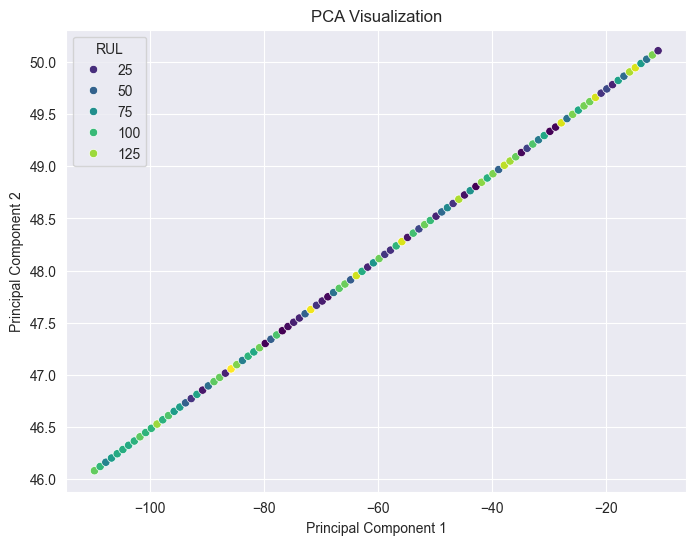

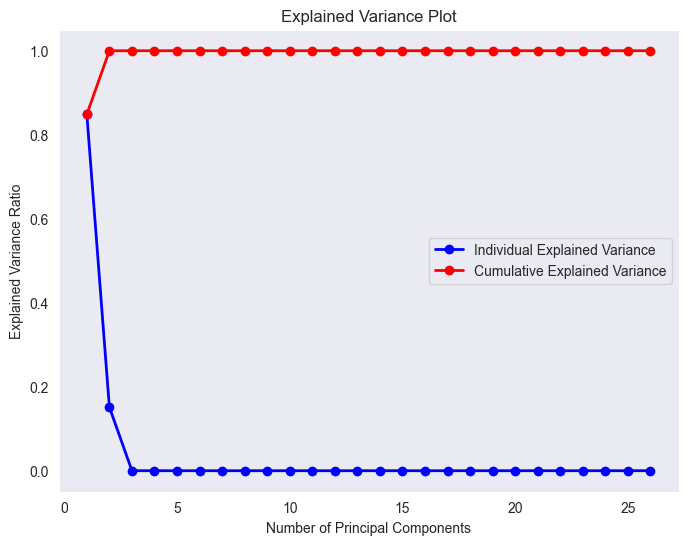

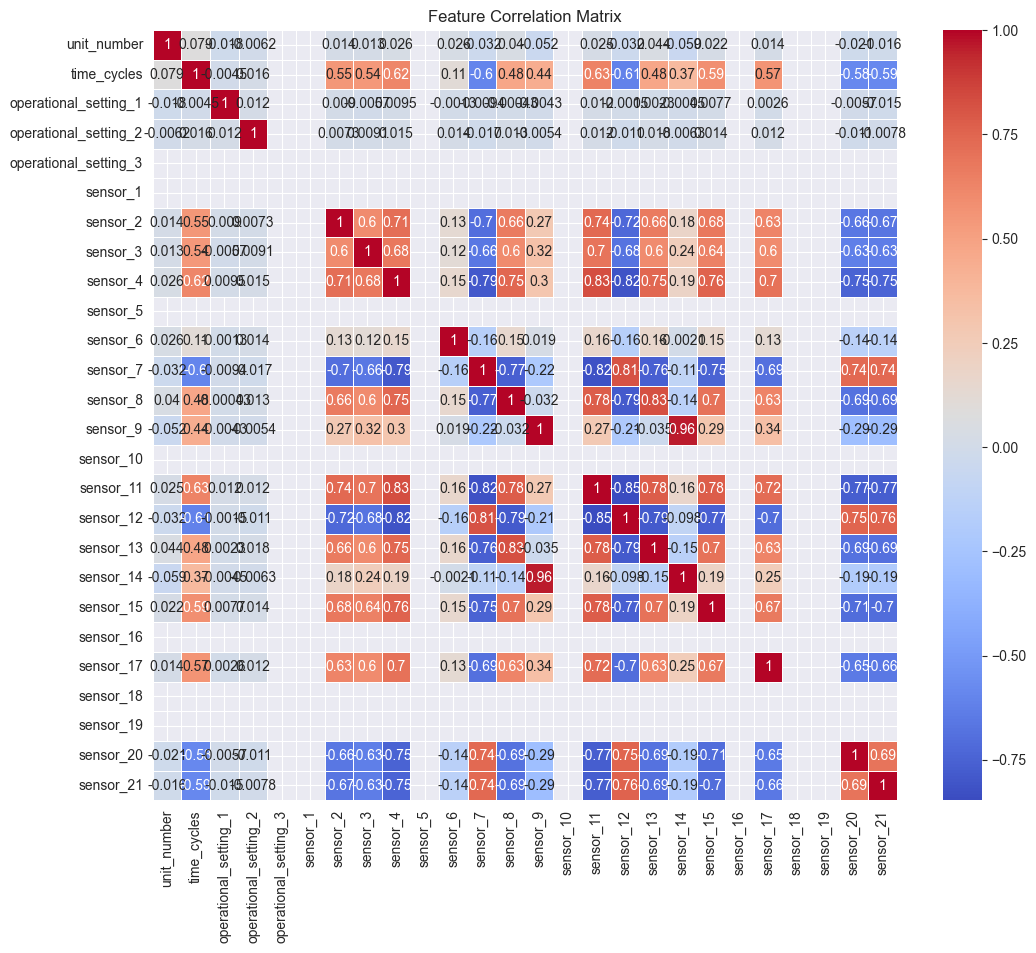

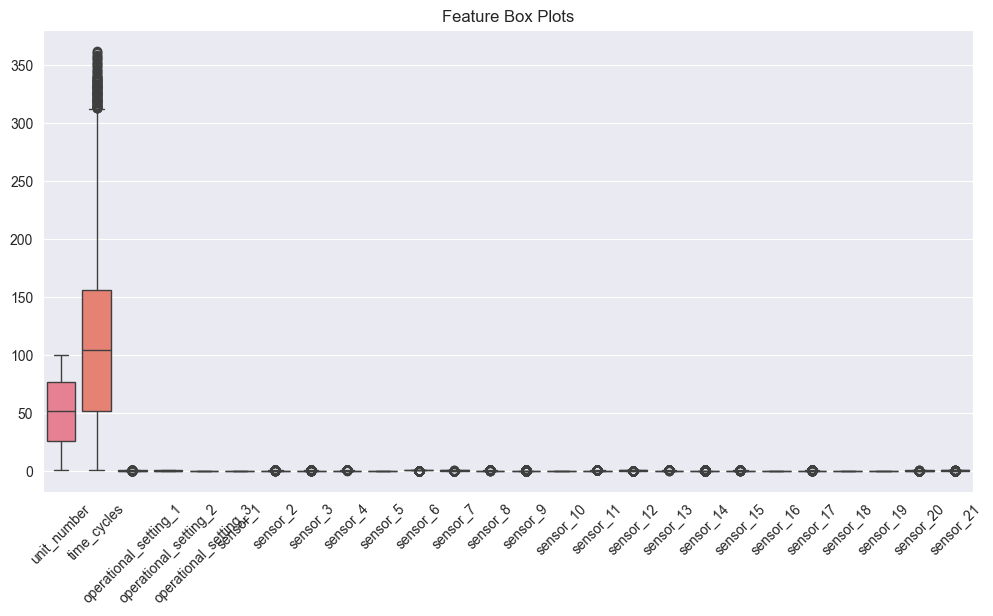

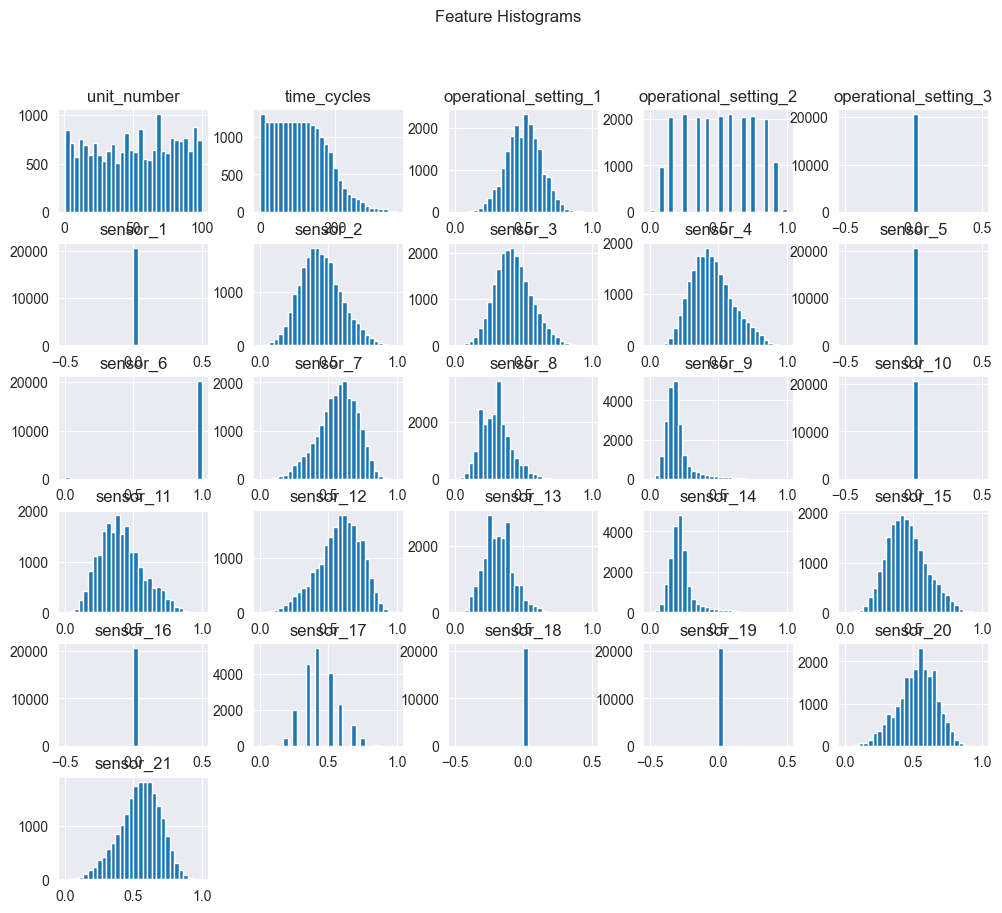

/var/folders/w5/xv2mxvzn2ns0szm6w3260jym0000gn/T/ipykernel_19058/1375266167.py:65: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], palette='viridis')


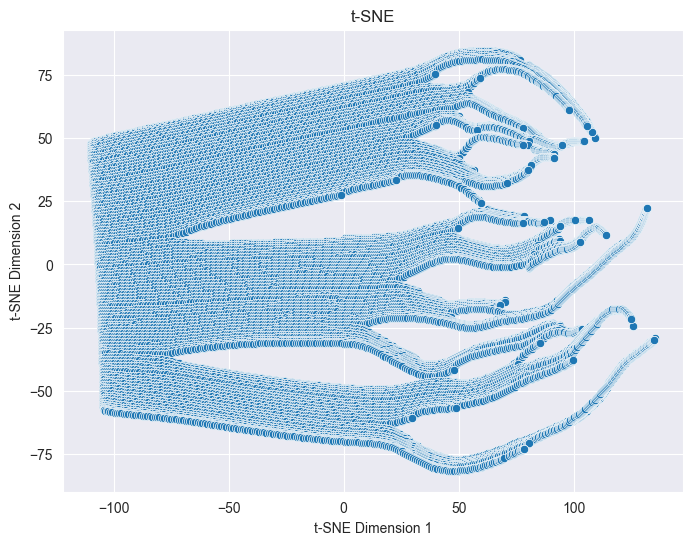

In [7]:
# PCA Visualization
def visualize_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization')
    plt.show()

# Explained Variance Plot
def plot_explained_variance(X):
    pca = PCA().fit(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    cum_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2, label='Individual Explained Variance')
    plt.plot(range(1, len(cum_explained_variance_ratio) + 1), cum_explained_variance_ratio, 'ro-', linewidth=2, label='Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Plot')
    plt.legend()
    plt.grid()
    plt.show()

# Feature Correlation Matrix
def plot_correlation_matrix(X):
    correlation_matrix = X.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.show()

# Box Plots
def plot_box_plots(X):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=X)
    plt.title('Feature Box Plots')
    plt.xticks(rotation=45)
    plt.show()

# Histograms
def plot_histograms(X):
    X.hist(figsize=(12, 10), bins=30)
    plt.suptitle('Feature Histograms')
    plt.show()

# t-SNE
def visualize_tsne(X):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], palette='viridis')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE')
    plt.show()


data = train_data.copy()  # Copy the data to avoid modifying the original data
rul_data = pd.read_csv(data_dir + '/RUL_FD001.txt', header=None, names=['RUL'])
data = pd.concat([data.reset_index(drop=True), rul_data], axis=1)

X = data.drop('RUL', axis=1)  # Remove the target variable
y = data['RUL']

# Call the visualization and analysis functions
visualize_pca(X, y)
plot_explained_variance(X)
plot_correlation_matrix(X)
plot_box_plots(X)
plot_histograms(X)
visualize_tsne(X)

#### t-SNE
<ul>
<li>The t-SNE plot shows the data points projected onto a two-dimensional space using the t-SNE algorithm.</li>
<li>There appear to be several distinct clusters or groups of data points, indicating potential patterns or similarities within the data.</li>
<li>The presence of separate clusters suggests that the data may have some inherent structure or groupings based on the selected features.</li>
</ul>

#### Feature Correlation Matrix
<ul>
<li>The feature correlation matrix shows the pairwise correlations between different features.</li>
<li>The diagonal elements have a correlation of 1, as each feature is perfectly correlated with itself.</li>
<li>There are some notable correlations between certain features, such as "sensor_6" and "sensor_7", "sensor_11" and "sensor_12", and "sensor_20" and "sensor_21".</li>
<li>The presence of high correlations between features may indicate redundancy or potential multicollinearity, which could be considered during feature selection.</li>
</ul>

#### Feature Box Plots
<ul>
<li>The box plots display the distribution of values for each feature.</li>
<li>Most of the features have a relatively narrow range of values, with a few outliers present (shown as individual points).</li>
<li>The median values (represented by the horizontal lines inside the boxes) vary across different features, indicating differences in the central tendencies.</li>
<li>The presence of outliers suggests that some data points have unusually high or low values compared to the majority of the data.</li>
</ul>

#### PCA Visualization
<ul>
<li>The PCA visualization shows the data points projected onto the first two principal components.</li>
<li>The data points are colored based on the RUL (Remaining Useful Life) values, with different colors representing different RUL ranges.</li>
<li>There is a visible separation between the data points with different RUL values, indicating that the first two principal components capture some information related to the RUL.</li>
<li>The separation becomes more pronounced as the RUL values decrease (from green to red), suggesting that the principal components are able to distinguish between different stages of the engine's remaining life.</li>
</ul>

#### Explained Variance Plot
<ul>
<li>The explained variance plot shows the proportion of variance explained by each principal component.</li>
<li>The plot includes both the individual explained variance ratios and the cumulative explained variance ratios.</li>
<li>The first principal component explains a significant portion of the total variance (around 80% or more), indicating that it captures a large amount of information from the original features.</li>
<li>As the number of principal components increases, the cumulative explained variance approaches 100%, suggesting that most of the variation in the data can be captured by a relatively small number of principal components.</li>
</ul>

#### Histograms
<ul>
<li>The unit_number and time_cycles features have quite different distributions. The unit_number features show a uniform distribution, while the time_cycles features have a right-skewed distribution.</li>
<li>The operational settings (operational_setting_1/2/3) generally show a distribution with two peaks. This may indicate that two different operational conditions are dominant in the dataset.</li>
<li>The sensor values exhibit various distributions. Some are close to a normal distribution (e.g., sensor_1, sensor_5, sensor_6), while others show more irregular and multimodal distributions (e.g., sensor_11, sensor_13, sensor_15, sensor_17). Further analysis and domain knowledge could help understand the underlying reasons for these distributions.</li>
<li>While some sensors spread over a wider range (e.g., sensor_2, sensor_14, sensor_21), others are concentrated in a narrower range (e.g., sensor_4, sensor_7, sensor_12). This gives an idea about the scales and variability of the sensors.</li>
<li>There appear to be notable outliers in sensor_9 and sensor_14. It may be necessary to investigate whether these are real readings or noise.</li>
</ul>

## Evaluation of Visualization Results
<ol>
<li><b>unit_number, time_cycles, and operational_setting_1-2-3</b>:
    <ul>
   <li>unit_number and time_cycles are necessary to uniquely identify each engine instance and track the progression of degradation over time.</li>
   <li>Operational settings reflect the operating conditions of the engine and can influence sensor readings. Including these features can enhance the model's generalization ability in different operating scenarios.</li>
   </ul>
</li>
<li><b>Sensor 2, 3, 4</b>:
    <ul>
   <li>These sensors are related to the low-pressure compressor (LPC) and can provide important information in the early stages of the fault progression process.</li>
   <li>>Including sensors related to the LPC can help detect fault initiation and offer additional insights for RUL estimation.</li>
   </ul>
</li>
<li><b>Sensor 7, 8, 9</b>:
   <ul>
   <li>These sensors are related to the high-pressure compressor (HPC), which is critically important, especially during the rapid deterioration stage of the fault progression.</li>
   <li>Eliminating Sensor 6 due to its high correlation with Sensor 7 will help prevent unnecessary information redundancy.</li>
   </ul>
</li>
<li><b>Sensor 12, 13, 14, 15</b>:
    <ul>
    <li>These sensors provide temperature measurements related to the turbine section (high and low-pressure turbines).</li>
    <li>Monitoring turbine temperatures can be crucial in detecting deterioration in engine performance and potential failures.</li>
    <li>These sensors can offer valuable information, especially in the advanced stages of the engine's degradation process.</li>
   </ul>
</li>
<li><b>Sensor 20</b>:
    <ul>
    <li>Sensor 20 measures the vibration levels of the engine and provides information about mechanical integrity.</li>
    <li>Vibration data can help detect abnormalities in rotating components such as bearings or gears.</li>
    <li>High vibration levels often indicate a decline in the engine's health and can be a precursor to impending failures.</li>
   </ul>
</li>
<li><b>Histogram, variance, and PCA analyses</b>:
    <ul>
   <li>These analyses confirm that the selected features are effective in capturing the information in the dataset.</li>
   <li>Histogram analysis shows that the distributions of the selected features represent the overall distributions in the dataset, which can be an indication that they are a representative feature subset.</li>
   <li>Variance analysis demonstrates that the selected features play a significant role in explaining the variability in the dataset.</li>
   <li>PCA results suggest that the selected features capture the underlying structures in the dataset and can be effective in reducing dimensionality.</li>
   </ul>
</li>
</ol>

### Preparation of Train and Test Data

In [10]:
def prepare_train_test_data(data_dir, train_files, test_files, rul_files, selected_columns):
    train_data_list = []
    test_data_list = []

    for i in range(len(train_files)):
        train_file = os.path.join(data_dir, train_files[i])
        test_file = os.path.join(data_dir, test_files[i])
        rul_file = os.path.join(data_dir, rul_files[i])

        # Load train dataset and select features
        train_data = pd.read_csv(train_file)
        train_data = train_data[selected_columns]

        # Load RUL values and add them to train dataset
        rul_data = pd.read_csv(rul_file, header=None, names=['RUL'])
        train_data['RUL'] = rul_data['RUL']

        # Load test dataset and select features
        test_data = pd.read_csv(test_file)
        test_data = test_data[selected_columns]

        # Add data to train_data_list and test_data_list
        train_data_list.append(train_data)
        test_data_list.append(test_data)

    # Merge all train and test data sets into one data set
    train_data_merged = pd.concat(train_data_list, ignore_index=True)
    test_data_merged = pd.concat(test_data_list, ignore_index=True)

    # Save data as CSV files
    train_data_merged.to_csv(os.path.join(data_dir, 'merged_train_data.csv'), index=False)
    test_data_merged.to_csv(os.path.join(data_dir, 'merged_test_data.csv'), index=False)

    print("Train and test data sets were prepared successfully.")

# Directory containing data sets
data_dir = "Data"

# Filenames of data sets
train_files = ['normalized_train_FD001.csv', 'normalized_train_FD002.csv', 'normalized_train_FD003.csv', 'normalized_train_FD004.csv']
test_files = ['normalized_test_FD001.csv', 'normalized_test_FD002.csv', 'normalized_test_FD003.csv', 'normalized_test_FD004.csv']
rul_files = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

# Selected features
selected_columns = ['unit_number', 'time_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3',
                    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_12', 'sensor_13',
                    'sensor_14', 'sensor_15', 'sensor_20']

# Prepare train and test data sets
prepare_train_test_data(data_dir, train_files, test_files, rul_files, selected_columns)

Train and test data sets were prepared successfully.


Since we have a time series, I thought of applying the following feature engineering methods to increase the prediction success.
<ol>
<li><b>Lag Features</b>:
    <ul>
    <li>Let's add sensor values from previous time steps as new features.</li>
    <li>For example, in addition to the sensor value at time t, we can include values at times t-1, t-2, t-3, etc.</li>
    <li>This allows the model to consider historical information and helps capture temporal dependencies.</li>
    </ul>
</li>
<li><b>Time Window Statistics</b>:
    <ul>
    <li>Let's calculate statistical summaries of sensor values over a specific time window.</li>
    <li>For example, we can calculate the minimum, maximum, mean, standard deviation, etc., for the last 10 time steps.</li>
    <li>These features capture variability and distribution over time.</li>
    </ul>
</li>
<li><b>Fourier Transform Features</b>:
    <ul>
    <li>Let's obtain frequency domain features by applying Fourier Transform to sensor data.</li>
    <li>These features can help capture periodic patterns or oscillations in the data.</li>
    <li>We can use the obtained frequency components or spectral densities as new features.</li>
    </ul>
</li>
</ol>

In [26]:
def create_lag_features(data, lag_steps):
    columns = data.columns
    lagged_data = pd.DataFrame()
    for lag in lag_steps:
        lagged = data.shift(lag)
        lagged_columns = [f"{col}_lag_{lag}" for col in columns]
        lagged.columns = lagged_columns
        lagged_data = pd.concat([lagged_data, lagged], axis=1)
    
    # Concatenate original data with lagged data
    data_with_lags = pd.concat([data, lagged_data], axis=1)
    
    data_with_lags.bfill(inplace=True)
    
    return data_with_lags

def create_window_statistics(data, window_size):
    columns = data.columns
    stats_dict = {}
    
    for col in columns:
        stats_dict[f"{col}_mean_{window_size}"] = data[col].rolling(window=window_size).mean()
        stats_dict[f"{col}_std_{window_size}"] = data[col].rolling(window=window_size).std()
        stats_dict[f"{col}_min_{window_size}"] = data[col].rolling(window=window_size).min()
        stats_dict[f"{col}_max_{window_size}"] = data[col].rolling(window=window_size).max()

    window_stats_data = pd.DataFrame(stats_dict, index=data.index)
    
    # Concatenate and optionally handle NaNs
    data_with_stats = pd.concat([data, window_stats_data], axis=1)
    
    # Fill NaNs if necessary
    data_with_stats.bfill(inplace=True)

    return data_with_stats

def create_fourier_features(data, n_components):
    columns = data.columns
    fourier_data = {}
    min_index_length = len(data)  # Use the full length unless a shorter series dictates otherwise
    
    for col in columns:
        clean_series = data[col].dropna()  # Drop NaN values before applying FFT
        fft_values = fft(clean_series.values)
        min_index_length = min(min_index_length, len(clean_series))  # Adjust based on the shortest series
        for i in range(1, n_components + 1):
            fourier_data[f"{col}_fft_{i}"] = np.abs(fft_values[i])

    fourier_df = pd.DataFrame(fourier_data, index=data.index[:min_index_length])  # Adjust index if needed
    data_with_fourier = pd.concat([data, fourier_df], axis=1)

    # Handling NaN generated from dropping values
    data_with_fourier.bfill(inplace=True)

    return data_with_fourier

# Directory containing data sets
data_dir = "Data"

train_data = pd.read_csv(os.path.join(data_dir, "merged_train_data.csv"))
test_data = pd.read_csv(os.path.join(data_dir, "merged_test_data.csv"))

# Specify the desired lag steps, window size, and number of Fourier components
lag_steps = [1, 2, 3]
window_size = 10
n_fourier_components = 5

# Create lag features
train_data_lag = create_lag_features(train_data, lag_steps)
test_data_lag = create_lag_features(test_data, lag_steps)

# Create time window statistics features
train_data_window = create_window_statistics(train_data_lag, window_size)
test_data_window = create_window_statistics(test_data_lag, window_size)

# Create Fourier transform features
train_data_fourier = create_fourier_features(train_data_window, n_fourier_components)
test_data_fourier = create_fourier_features(test_data_window, n_fourier_components)

# Save the updated train and test data with new features
train_data_fourier.to_csv(os.path.join(data_dir, "train_data_engineered.csv"), index=False)
test_data_fourier.to_csv(os.path.join(data_dir, "test_data_engineered.csv"), index=False)

## Fuzzy Logic

In [2]:
class FuzzyRule:
    def __init__(self, antecedents, consequent):
        self.antecedents = antecedents
        self.consequent = consequent
    
    def evaluate(self, input_values):
        # Evaluate the fuzzy rule using the input values
        firing_strength = 1
        for antecedent, value in zip(self.antecedents, input_values):
            firing_strength *= fuzz.interp_membership(antecedent.universe, antecedent.mf, value)
        
        return firing_strength

class Individual:
    def __init__(self, rules):
        self.rules = rules
    
    def evaluate(self, X):
        # Evaluate the individual using the input data X
        y_pred = []
        for x in X:
            firing_strengths = [rule.evaluate(x) for rule in self.rules]
            aggregated = np.max(firing_strengths)
            y_pred.append(fuzz.defuzz(y.universe, aggregated, 'centroid'))
        
        return np.array(y_pred)

In [3]:
# Define the linguistic variables and fuzzy sets
x1_universe = np.arange(0, 1.01, 0.01)
x2_universe = np.arange(0, 1.01, 0.01)
y_universe = np.arange(0, 1.01, 0.01)

x1_low = fuzz.trimf(x1_universe, [0, 0, 0.5])
x1_medium = fuzz.trimf(x1_universe, [0, 0.5, 1])
x1_high = fuzz.trimf(x1_universe, [0.5, 1, 1])

x2_low = fuzz.trimf(x2_universe, [0, 0, 0.5])
x2_medium = fuzz.trimf(x2_universe, [0, 0.5, 1])
x2_high = fuzz.trimf(x2_universe, [0.5, 1, 1])

y_low = fuzz.trimf(y_universe, [0, 0, 0.5])
y_medium = fuzz.trimf(y_universe, [0, 0.5, 1])
y_high = fuzz.trimf(y_universe, [0.5, 1, 1])

# Define the fuzzy variables
x1 = ctrl.Antecedent(x1_universe, 'x1')
x2 = ctrl.Antecedent(x2_universe, 'x2')
y = ctrl.Consequent(y_universe, 'y')

# Define the fuzzy sets for each variable
x1['low'] = x1_low
x1['medium'] = x1_medium
x1['high'] = x1_high

x2['low'] = x2_low
x2['medium'] = x2_medium
x2['high'] = x2_high

y['low'] = y_low
y['medium'] = y_medium
y['high'] = y_high

# Define the fuzzy rules
rule1 = ctrl.Rule(x1['low'] & x2['low'], y['low'])
rule2 = ctrl.Rule(x1['medium'] & x2['medium'], y['medium'])
rule3 = ctrl.Rule(x1['high'] | x2['high'], y['high'])

# Create the fuzzy control system
fuzzy_system = ctrl.ControlSystem([rule1, rule2, rule3])
fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_system)

## Genetic Programming

To represent and evolve fuzzy rules using genetic programming (GP), we can follow the following steps:

#### Representation of Fuzzy Rules:
<ul>
<li>We can use tree structure to represent fuzzy rules.</li>
<li>Each tree represents a fuzzy rule.</li>
<li>Internal nodes of the tree contain fuzzy logic operators (AND, OR) and comparison operators (<, >, ==).</li>
<li>Leaf nodes of the tree represent fuzzy membership functions (e.g., low, medium, high) or numerical values.</li>
<li>Each rule calculates the fuzzy membership degrees of the input variables and produces an output membership degree.</li>
</ul>


In [10]:
def tournament_selection(population, tournament_size):
    selected = []
    for _ in range(tournament_size):
        candidate = random.choice(population)
        selected.append(candidate)
    winner = max(selected, key=lambda ind: ind.fitness)
    return winner

def random_subtree(individual):
    # Randomly select a rule from the individual
    rule = random.choice(individual.rules)
    # Randomly select an antecedent or consequent from the rule
    subtree = random.choice(rule.antecedents + [rule.consequent])
    return subtree

def swap_subtrees(individual, subtree1, subtree2):
    # Find the rules containing the subtrees
    rule1 = next(rule for rule in individual.rules if subtree1 in rule.antecedents + [rule.consequent])
    rule2 = next(rule for rule in individual.rules if subtree2 in rule.antecedents + [rule.consequent])
    
    # Swap the subtrees
    if subtree1 in rule1.antecedents:
        index1 = rule1.antecedents.index(subtree1)
        rule1.antecedents[index1] = subtree2
    else:
        rule1.consequent = subtree2
    
    if subtree2 in rule2.antecedents:
        index2 = rule2.antecedents.index(subtree2)
        rule2.antecedents[index2] = subtree1
    else:
        rule2.consequent = subtree1

def generate_random_subtree(variables):
    # Randomly select a fuzzy variable from the provided variables
    variable = random.choice(variables)
    # Randomly select a fuzzy set from the variable
    fuzzy_set = random.choice(list(variable.terms.values()))
    return fuzzy_set

def replace_subtree(individual, old_subtree, new_subtree):
    # Find the rule containing the old subtree
    rule = next(rule for rule in individual.rules if old_subtree in rule.antecedents + [rule.consequent])
    
    # Replace the old subtree with the new subtree
    if old_subtree in rule.antecedents:
        index = rule.antecedents.index(old_subtree)
        rule.antecedents[index] = new_subtree
    else:
        rule.consequent = new_subtree

def subtree_crossover(parent1, parent2):
    offspring1 = copy.deepcopy(parent1)
    offspring2 = copy.deepcopy(parent2)
    
    # Select random subtree from parent1
    subtree1 = random_subtree(offspring1)
    
    # Select random subtree from parent2
    subtree2 = random_subtree(offspring2)
    
    # Swap the selected subtrees
    swap_subtrees(offspring1, subtree1, subtree2)
    
    return offspring1, offspring2

def subtree_mutation(individual):
    mutated = copy.deepcopy(individual)
    
    # Select a random subtree
    subtree = random_subtree(mutated)
    
    # Replace the subtree with a randomly generated subtree
    new_subtree = generate_random_subtree()
    replace_subtree(mutated, subtree, new_subtree)
    
    return mutated

def evaluate_individual(individual, X):
    # Create a new fuzzy control system using the individual's rules
    fuzzy_system = ctrl.ControlSystem(individual.rules)
    fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_system)
    
    # Evaluate the individual for each input data point
    y_pred = []
    for x in X:
        # Set input values for the fuzzy simulator
        for i, var in enumerate([x1, x2]):
            fuzzy_simulator.input[var.label] = x[i]
        
        # Compute the output using the fuzzy simulator
        fuzzy_simulator.compute()
        
        # Append the defuzzified output to the predicted values
        y_pred.append(fuzzy_simulator.output['y'])
    
    return np.array(y_pred)

def evaluate_fitness(individual, X, y, alpha=0.5):
    y_pred = evaluate_individual(individual, X)
    
    # Compute mean absolute error for prediction accuracy
    mae = mean_absolute_error(y, y_pred)
    
    # Compute interpretability score based on rule count and rule length
    rule_count = len(individual.rules)
    avg_rule_length = sum(len(rule.antecedents) for rule in individual.rules) / rule_count
    interpretability_score = 1 / (1 + rule_count + avg_rule_length)
    
    # Combine prediction accuracy and interpretability scores
    fitness = alpha * (1 / mae) + (1 - alpha) * interpretability_score
    return fitness

def generate_random_individual(x1, x2, y):
    rules = []
    used_consequents = []
    
    # Generate rules for all combinations of input variables and linguistic terms
    for x1_term in x1.terms.values():
        for x2_term in x2.terms.values():
            antecedent = x1_term & x2_term
            consequent = generate_random_subtree([y])
            rule = Rule(antecedent, consequent)
            rules.append(rule)
            used_consequents.append(consequent)
    
    # Generate additional random rules
    for _ in range(random.randint(3, 10)):
        antecedents = []
        for _ in range(random.randint(1, 2)):
            antecedent = generate_random_subtree([x1, x2])
            antecedents.append(antecedent)
        
        consequent = None
        while consequent is None or consequent in used_consequents:
            consequent = generate_random_subtree([y])
        used_consequents.append(consequent)
        
        rule = Rule(np.prod(antecedents) if len(antecedents) == 1 else antecedents[0] & antecedents[1], consequent)
        rules.append(rule)
    
    individual = Individual(rules)
    return individual

## Experiments

The below code implements a genetic programming algorithm to optimize the performance of a fuzzy control system. The algorithm takes as input a training dataset, which consists of input-output pairs. The output is the performance of the fuzzy control system on a testing dataset. The algorithm uses a genetic programming approach to evolve the fuzzy control system's rules and parameters.

In [15]:
# Hyperparameter ranges
population_sizes = [20, 30, 50]
generation_counts = [5, 10, 15]
tournament_sizes = [2, 3, 4]
crossover_rates = [0.7, 0.80, 0.85]
mutation_rates = [0.06, 0.08, 0.1]

# Load the training dataset
data = pd.read_csv('Data/train_data_engineered.csv')
X_data = data.drop('RUL', axis=1).values
y_data = data['RUL'].values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# DataFrame to store experiment results
results_df = pd.DataFrame(columns=['Population Size', 'Generations', 'Tournament Size',
                                   'Crossover Rate', 'Mutation Rate', 'Train MAE',
                                   'Train MSE', 'Train R-squared', 'Test MAE',
                                   'Test MSE', 'Test R-squared', 'Best Individual',
                                   'X_train', 'y_train', 'X_test', 'y_test'])

# Perform experiments
for pop_size in population_sizes:
    for generations in generation_counts:
        for tournament_size in tournament_sizes:
            for crossover_rate in crossover_rates:
                for mutation_rate in mutation_rates:
                    # Generate initial population randomly
                    population = [generate_random_individual(x1, x2, y) for _ in range(pop_size)]
                    
                    # Genetic programming loop
                    for generation in range(generations):
                        # Evaluate individuals
                        for individual in population:
                            individual.fitness = evaluate_fitness(individual, X_train, y_train)
                        
                        # Select the best individual
                        best_individual = max(population, key=lambda ind: ind.fitness)
                        
                        # Create new population
                        new_population = []
                        while len(new_population) < pop_size:
                            parent1 = tournament_selection(population, tournament_size)
                            parent2 = tournament_selection(population, tournament_size)
                            
                            if np.random.rand() < crossover_rate:
                                offspring1, offspring2 = subtree_crossover(parent1, parent2)
                                new_population.extend([offspring1, offspring2])
                            else:
                                new_population.extend([parent1, parent2])
                        
                        # Apply mutation
                        for individual in new_population:
                            if np.random.rand() < mutation_rate:
                                mutated_individual = subtree_mutation(individual)
                                individual.rules = mutated_individual.rules
                        
                        population = new_population
                    
                    # Evaluate the best individual on the training set
                    y_pred_train = evaluate_individual(best_individual, X_train)
                    train_mae = mean_absolute_error(y_train, y_pred_train)
                    train_mse = mean_squared_error(y_train, y_pred_train)
                    train_r2 = r2_score(y_train, y_pred_train)
                    
                    # Evaluate the best individual on the testing set
                    y_pred_test = evaluate_individual(best_individual, X_test)
                    test_mae = mean_absolute_error(y_test, y_pred_test)
                    test_mse = mean_squared_error(y_test, y_pred_test)
                    test_r2 = r2_score(y_test, y_pred_test)
                    
                    # Add results to DataFrame
                    results_df = results_df.append({
                        'Population Size': pop_size,
                        'Generations': generations,
                        'Tournament Size': tournament_size,
                        'Crossover Rate': crossover_rate,
                        'Mutation Rate': mutation_rate,
                        'Train MAE': train_mae,
                        'Train MSE': train_mse,
                        'Train R-squared': train_r2,
                        'Test MAE': test_mae,
                        'Test MSE': test_mse,
                        'Test R-squared': test_r2,
                        'Best Individual': best_individual,
                        'X_train': X_train.tolist(),
                        'y_train': y_train.tolist(),
                        'X_test': X_test.tolist(),
                        'y_test': y_test.tolist()
                    }, ignore_index=True)
                    
                    # Print the experiment results
                    print("Experiment Results:")
                    print(results_df.tail(1))
                    print()

# Save experiment results to file
results_df.to_csv('Data/experiment_results.csv', index=False)


KeyboardInterrupt: 

I tried a new experiment. The previous one was not finished. So, I considered changing the dataset for a small one, and I chanced the GP parameters.

In [17]:
# Genetic programming parameters
POPULATION_SIZE = 30
GENERATIONS = 1
TOURNAMENT_SIZE = 1
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.06

# DataFrame to store experiment results
results_df = pd.DataFrame(columns=['Population Size', 'Generations', 'Tournament Size',
                                   'Crossover Rate', 'Mutation Rate', 'Train MAE',
                                   'Train MSE', 'Train R-squared', 'Test MAE',
                                   'Test MSE', 'Test R-squared'])


# Load the training dataset
data = pd.read_csv('Data/merged_train_data.csv')
X_data = data.drop('RUL', axis=1).values
y_data = data['RUL'].values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


# Generate initial population randomly
population = [generate_random_individual(x1, x2, y) for _ in range(POPULATION_SIZE)]


# Genetic programming loop
for generation in range(GENERATIONS):
    # Evaluate individuals
    for individual in population:
        individual.fitness = evaluate_fitness(individual, X_train, y_train)

    # Select the best individual
    best_individual = max(population, key=lambda ind: ind.fitness)

    # Create new population
    new_population = []
    while len(new_population) < POPULATION_SIZE:
        # Select parents using tournament selection
        parent1 = tournament_selection(population, TOURNAMENT_SIZE)
        parent2 = tournament_selection(population, TOURNAMENT_SIZE)

        # Apply crossover
        if np.random.rand() < CROSSOVER_RATE:
            offspring1, offspring2 = subtree_crossover(parent1, parent2)
            new_population.extend([offspring1, offspring2])
        else:
            new_population.extend([parent1, parent2])

    # Apply mutation
    for individual in new_population:
        if np.random.rand() < MUTATION_RATE:
            mutated_individual = subtree_mutation(individual)
            individual.rules = mutated_individual.rules

    population = new_population

    # Evaluate the best individual on the testing set
    best_fitness = evaluate_fitness(best_individual, X_test, y_test)
    print(f"Generation {generation+1}: Best Fitness = {best_fitness}")

# Select the best individual
best_individual = max(population, key=lambda ind: ind.fitness)

# Evaluate the best individual on the testing set
y_pred = evaluate_individual(best_individual, X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Evaluate the best individual on the training set
y_pred_train = evaluate_individual(best_individual, X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Evaluate the best individual on the testing set
y_pred_test = evaluate_individual(best_individual, X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Add results to DataFrame
results_df = results_df.append({
    'Population Size': POPULATION_SIZE,
    'Generations': GENERATIONS,
    'Tournament Size': TOURNAMENT_SIZE,
    'Crossover Rate': CROSSOVER_RATE,
    'Mutation Rate': MUTATION_RATE,
    'Train MAE': train_mae,
    'Train MSE': train_mse,
    'Train R-squared': train_r2,
    'Test MAE': test_mae,
    'Test MSE': test_mse,
    'Test R-squared': test_r2
}, ignore_index=True)

# Save experiment results to file
results_df.to_csv('Data/experiment_result1.csv', index=False)
print(f"Best Individual Performance:")
print(f"Population Size: {POPULATION_SIZE}")
print(f"Generations: {GENERATIONS}")
print(f"Tournament Size: {TOURNAMENT_SIZE}")
print(f"Crossover Rate: {CROSSOVER_RATE}")
print(f"Mutation Rate: {MUTATION_RATE}")
print(f"Train MAE: {mse}")
print(f"Train MAE: {train_mae}")
print(f"Train MSE: {train_mse}")
print(f"Train R-squared: {train_r2}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test R-squared: {test_r2}")


KeyboardInterrupt: 

## Analysis of Results

In [ ]:

def analyze_interpretability(best_individual, X_train, y_train, X_test, y_test, results_df):
    # Evaluate the best individual on the training set
    y_pred_train = evaluate_individual(best_individual, X_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    # Evaluate the best individual on the testing set
    y_pred_test = evaluate_individual(best_individual, X_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Analyze the interpretability of the evolved fuzzy rules
    rule_counts = results_df['Rule Count'].values
    avg_rule_lengths = results_df['Avg. Rule Length'].values
    
    print("Interpretability Analysis:")
    print(f"Number of Rules: {rule_counts}")
    print(f"Average Rule Length: {avg_rule_lengths}")
    print(f"Training Performance - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, R-squared: {train_r2:.4f}")
    print(f"Testing Performance - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, R-squared: {test_r2:.4f}")
    
    # Visualize the relationship between rule base size and performance
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rule_counts, results_df['Test MAE'], label='Test MAE')
    ax.scatter(rule_counts, results_df['Test MSE'], label='Test MSE')
    ax.set_xlabel('Number of Rules')
    ax.set_ylabel('Performance')
    ax.set_title('Relationship between Rule Base Size and Performance')
    ax.legend()
    plt.show()
    
    # Visualize the distribution of rule lengths
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(avg_rule_lengths, bins=20, kde=True, ax=ax)
    ax.set_xlabel('Average Rule Length')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Average Rule Lengths')
    plt.show()
    
    # Print the evolved fuzzy rules for expert interpretation
    print("Evolved Fuzzy Rules:")
    for i, rule in enumerate(best_individual.rules, start=1):
        print(f"Rule {i}: {rule}")
        
        
# Load experiment results from file
results_df = pd.read_csv('Data/experiment_results.csv')

# Perform interpretability analysis for each experiment
for _, row in results_df.iterrows():
    best_individual = Individual(eval(row['Best Individual']))
    X_train = np.array(eval(row['X_train']))
    y_train = np.array(eval(row['y_train']))
    X_test = np.array(eval(row['X_test']))
    y_test = np.array(eval(row['y_test']))
    
    analyze_interpretability(best_individual, X_train, y_train, X_test, y_test, results_df)

